# Organising Daily Life Data using the GMAC algorithm

This notebook analyses the daily life data collected from 5 stroke suvivors and
healthy controls, wearing the IMU sensors for 7 days and 3 days, respectively.

The parameters for the GMAC algorithm are taken from the optimal values identified 
from the optimization procedure.

### Getting the data

If you do not already have the data to run this this notebook, you need to
download it from here.



### Standards modules

In [ ]:
%reload_ext autoreload
%autoreload 2

In [1]:
import sys
import os
import scipy
import pathlib
import itertools
import glob
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy import signal
from scipy.interpolate import interp1d
from datetime import datetime as dt

In [2]:
import seaborn as sns

### Custom Modules

In [3]:
sys.path.append("../scripts")

from misc2 import organize_rawdata_datewise
from misc2 import read_raw_data
from misc2 import read_raw_date_data
from misc2 import interp1d_rawdata

## Custom functions

In [4]:
def organize_processed_data(src_fname, arm, subj, Fs, data_cols, accl_scale, gyro_scale):
    """
    Organize raw data into processed data.
    """
    # When to dump data to the disk.
    n_dump = 3600
    
    # Processed file name
    prcd_fname = '_pcrd_'.join(src_fname.split('_raw_'))
    
    # Read data source data.
    _rawdata = pd.read_csv(src_fname, sep=",", index_col=None, parse_dates=True)
    _rawdata['datetime'] = pd.to_datetime(_rawdata['datetime'])
    
    # Get the seconds that are recoeded.
    _secs = np.sort(np.unique(_rawdata['datetime'].unique()))

    # Go through each second and find the number of data points
    _data = None
    n_count = 0

    for _s in _secs:
        # Get time index.
        _inx = _rawdata['datetime'] == _s
        _ninx = np.sum(_inx)
        if _ninx == Fs:
            # All good.
            _tempdf = _rawdata.loc[_inx, :].reset_index(drop=True)
            _tempdf['datetime'] = _s + pd.Timedelta(seconds=1/Fs) * np.arange(0, Fs)
        elif np.abs(_ninx - Fs) < 10:
            # Minon mismatch
            # Interpolate, assuming uniform sampling
            _ynew = interp1d_rawdata(
                yvals=_rawdata.loc[_inx, data_cols].values,
                xold=np.arange(0, Fs, Fs / _ninx),
                xnew=np.arange(Fs),
            )
            _tempdf = pd.DataFrame(data=_ynew, columns=data_cols)
            _tempdf['datetime'] = _s + pd.Timedelta(seconds=1/Fs) * np.arange(0, Fs)
            
        # Update dataframe
        if _data is None:
            # Init if it does not exist
            _data = pd.DataFrame(columns=_tempdf.columns)
            _data.to_csv(prcd_fname, sep=",", mode='w', index=False, header=True)
        else:
            _data = pd.concat([_data, _tempdf], axis=0, ignore_index=True)
        
        # Check if data is to be dumped to the disk.
        if n_count == n_dump:
            # Dump data
            # Scale accelerometer and gyroscope values
            _data.loc[:, ['ax', 'ay', 'az']] = _data.loc[:, ['ax', 'ay', 'az']].values * accl_scale
            _data.loc[:, ['gx', 'gy', 'gz']] = _data.loc[:, ['gx', 'gy', 'gz']].values * gyro_scale
            _data.to_csv(prcd_fname, sep=",", mode='a', index=False, header=False)
            n_count = 0
            _data = pd.DataFrame(columns=_data.columns)
        else:
            n_count += 1
        
        # Update display
        if n_count % 73 == 0:
            sys.stdout.write(f"\rProcessing {arm:>5} {subj:>3} {_s} {_ninx:3d} {n_count:6d}")
            sys.stdout.flush()
    
    # Dump the remaining data
    # Scale accelerometer and gyroscope values
    _data.loc[:, ['ax', 'ay', 'az']] = _data.loc[:, ['ax', 'ay', 'az']].values * accl_scale
    _data.loc[:, ['gx', 'gy', 'gz']] = _data.loc[:, ['gx', 'gy', 'gz']].values * gyro_scale
    _data.to_csv(prcd_fname, sep=",", mode='a', index=False, header=False)

In [5]:
def get_subj_arm_fnames(details, data_dir):
    """
    Get list of subjects, arms, and rawfilenames.
    """
    for subj in details["names"]:
        for arm in ("left", "right"):
            # List of raw files.
            _path = pathlib.Path(data_dir / "processed" / subj / f"*{arm}*raw*.csv")
            _rawfiles = glob.glob(_path.as_posix())
            # Go through the raw files
            for fname in _rawfiles:
                yield (subj, arm, fname)

In [6]:
def get_list_of_files(base_data_dir, subj, arm, details):
    # Check if the processed folder exits.
    _prcddir = base_data_dir / "processed" / subj
    pathlib.Path(_prcddir).mkdir(exist_ok=True)

    # Remove all CSV files.
    for f in glob.glob(pathlib.Path(_prcddir / f"*{arm}*raw*.csv").as_posix()):
        os.remove(f)
    
    return _prcddir, [_f for _f in details['files'][subj] if arm in _f]


def all_files_iterator(files):
    for i, _f in enumerate(_files):
        yield i, _f,  _f.split(os.sep)[-1]
        

def read_data_dates_from_file(fname, rd_cols, dlim=2018):
    # Read data
    _data = read_raw_data(data_path=_fname, colnames=rd_cols)
    # Find the dates in the data.
    _dates = np.unique([_d.date() for _d in _data['datetime'] if _d.year >= dlim])
    return _data, _dates

def write_dates_data_to_disk(data, dates, prcddir, arm, dispstr):
    for _d in dates:
        # Find index from the current data with the date.
        _dinx = np.array([_dc.date() == _d for _dc in data['datetime']])
        
        # If file exists, then open, append and save.
        _prcd_fname = prcddir / f"{arm}_raw_{str(_d)}.csv"
        if pathlib.Path(_prcd_fname).is_file():
            sys.stdout.write(dispstr + f" {_d} Old")
            data.loc[_dinx, :].to_csv(_prcd_fname, sep=",", mode='a',
                                      header=False, index=False)
        else:
            sys.stdout.write(dispstr + f" {_d} New")
            data.loc[_dinx, :].to_csv(_prcd_fname, sep=",", index=False)
        sys.stdout.flush()

## Define notebook level constants

In [7]:
# Sampling rate for the data is 50ms
dT = 0.02
Fs = int(1 / dT)

# Raw data columns
rd_cols = rd_cols = ["ax", "ay", "az", "gx", "gy", "gz", "datetime", "yaw", "pitch"]
data_cols = [_el for _el in rd_cols if _el != "datetime"]

# Acclerometer and gyroscope scaling factors.
accl_scale = 4 / 32768.
gyro_scale = 0.0174533 / 65.536

## Read the Controls and Patients Data

In [8]:
# Read the stroke and healthy data folder structure and file names
base_data_dir = pathlib.Path("..", "..", "..", "..", "uploads", "uploads", "IMU home study")

_alldirs = glob.glob(pathlib.Path(base_data_dir / "raw", "*").as_posix())
controls_details = {
    "names": [_dir.split(os.sep)[-1] for _dir in _alldirs
              if "C" in _dir.split(os.sep)[-1]]
}
patients_details = {
    "names": [_dir.split(os.sep)[-1] for _dir in _alldirs
              if "P" in _dir.split(os.sep)[-1]]
}

# Get all patients and controls files names.
controls_details["files"] = {
    _name: glob.glob(pathlib.Path(base_data_dir / "raw", _name, "*").as_posix())
    for _name in controls_details["names"]
}
patients_details["files"] = {
    _name: glob.glob(pathlib.Path(base_data_dir / "raw", _name, "*").as_posix())
    for _name in patients_details["names"]
}

## Organize data into datewise files

In [11]:
# Create a processed file to avoid reprocessing the data.
datewise_rawdata_file = pathlib.Path(base_data_dir / "processed" / "datewise_rawdata.json")
if datewise_rawdata_file.exists():
    with open(datewise_rawdata_file, 'r') as f:
        try:
            datewise_rawdata = json.load(f)
        except json.JSONDecodeError:
            datewise_rawdata = {}
else:
    with open(datewise_rawdata_file, 'w') as f:
        datewise_rawdata = {}
        json.dump(datewise_rawdata, f, indent=4)

In [12]:
# Controls
# Organize raw data into datewise CSV files.
for subj in controls_details["names"]:
    # Check if subj is in datewise raw data.
    if subj not in datewise_rawdata.keys():
        datewise_rawdata[subj] = {} 
    
    for arm in ("left", "right"):
        # Check if the arm is in dateise raw data.
        if arm not in datewise_rawdata[subj].keys():
            datewise_rawdata[subj][arm] = []
        
        # Read the list of files.
        _prcddir, _files = get_list_of_files(base_data_dir, subj, arm, controls_details)       
        _nf = len(_files)
        
        # Go through each file and generate datewise data.
        for i, _fname, _fname_short in all_files_iterator(_files):
            # Update display
            _str = f"\r{i:3d} / {_nf:3d} {subj:>4} {_fname_short:>25} {' ':>15}"
            sys.stdout.write(_str)
            
            # Check if the file has been already processed.
            if _fname in datewise_rawdata[subj][arm]:
                continue
            
            # File not processed. Process.
            # Read data and dates
            _data, _dates = read_data_dates_from_file(_fname, rd_cols)
            
            # Write datewise data to disk.
            write_dates_data_to_disk(_data, _dates, _prcddir, arm, _str)
            
            # Update processed files and write to disk
            datewise_rawdata[subj][arm].append(_fname)
            with open(datewise_rawdata_file, "w") as f:
                json.dump(datewise_rawdata, f, indent=4)

188 / 206   C1          left_comp_15.csv                 2019-09-12 Old

/Users/siva82kb/Library/CloudStorage/OneDrive-ChristianMedicalCollege/projects/ArmUse/gmac/notebooks/../scripts/misc2.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _data['datetime'] = pd.to_datetime(_data['datetime'])


 61 /  71   C2         left_comp_111.csv                 2019-10-12 Old

/Users/siva82kb/Library/CloudStorage/OneDrive-ChristianMedicalCollege/projects/ArmUse/gmac/notebooks/../scripts/misc2.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _data['datetime'] = pd.to_datetime(_data['datetime'])


 92 /  93   C2        right_comp_155.csv                 2019-10-12 Old

In [18]:
# Patients
# Organize raw data into datewise CSV files.
for subj in patients_details["names"]:
    # Check if subj is in datewise raw data.
    if subj not in datewise_rawdata.keys():
        datewise_rawdata[subj] = {} 
    
    for arm in ("left", "right"):
        # Check if the arm is in dateise raw data.
        if arm not in datewise_rawdata[subj].keys():
            datewise_rawdata[subj][arm] = []
        
        # Read the list of files.
        _prcddir, _files = get_list_of_files(base_data_dir, subj, arm, patients_details)       
        _nf = len(_files)
        
        # Go through each file and generate datewise data.
        for i, _fname, _fname_short in all_files_iterator(_files):
            # Update display
            _str = f"\r{i:3d} / {_nf:3d} {subj:>4} {_fname_short:>25} {' ':>15}"
            sys.stdout.write(_str)
            
            # Check if the file has been already processed.
            if _fname in datewise_rawdata[subj][arm]:
                continue
            
            # File not processed. Process.
            # Read data and dates
            _data, _dates = read_data_dates_from_file(_fname, rd_cols)
            
            # Write datewise data to disk.
            write_dates_data_to_disk(_data, _dates, _prcddir, arm, _str)
            
            # Update processed files and write to disk
            datewise_rawdata[subj][arm].append(_fname)
            with open(datewise_rawdata_file, "w") as f:
                json.dump(datewise_rawdata, f, indent=4)

527 / 569   P4        right_comp_183.csv                 2019-12-29 Old

/Users/siva82kb/Library/CloudStorage/OneDrive-ChristianMedicalCollege/projects/ArmUse/gmac/notebooks/../scripts/misc2.py:19: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  _data = pd.read_csv(data_path, sep=',', header=None, index_col=False)


221 / 248   P3          left_comp_16.csv                 2019-10-08 Old

/Users/siva82kb/Library/CloudStorage/OneDrive-ChristianMedicalCollege/projects/ArmUse/gmac/notebooks/../scripts/misc2.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _data['datetime'] = pd.to_datetime(_data['datetime'])


194 / 351   P3         right_comp_16.csv                 2019-10-07 Old

/Users/siva82kb/Library/CloudStorage/OneDrive-ChristianMedicalCollege/projects/ArmUse/gmac/notebooks/../scripts/misc2.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _data['datetime'] = pd.to_datetime(_data['datetime'])


 50 / 288   P2        left_comp_1301.csv                 2019-09-28 Old

/Users/siva82kb/Library/CloudStorage/OneDrive-ChristianMedicalCollege/projects/ArmUse/gmac/notebooks/../scripts/misc2.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _data['datetime'] = pd.to_datetime(_data['datetime'])


 69 / 288   P2        left_comp_1302.csv                 2019-09-28 Old

/Users/siva82kb/Library/CloudStorage/OneDrive-ChristianMedicalCollege/projects/ArmUse/gmac/notebooks/../scripts/misc2.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _data['datetime'] = pd.to_datetime(_data['datetime'])


287 / 288   P1        right_comp_633.csv                 2019-08-23 Old

## Clean up data for analysis

In [9]:
def organize_data_for_second(rawdata, sec, Fs, rd_cols, data_cols):
    """
    Organize the data for the given second.
    """
    # Get time index.
    _inx = rawdata['datetime'] == sec
    _ninx = np.sum(_inx)
    if _ninx == Fs:
        # All good.
        _tempdf = rawdata.loc[_inx, :].reset_index(drop=True)
        _tempdf['datetime'] = sec + pd.Timedelta(seconds=1/Fs) * np.arange(0, Fs)
    elif np.abs(_ninx - Fs) < 10:
        # Minor mismatch
        # Interpolate, assuming uniform sampling
        _ynew = interp1d_rawdata(
            yvals=rawdata.loc[_inx, data_cols].values,
            xold=np.arange(0, Fs, Fs / _ninx),
            xnew=np.arange(Fs),
        )
        _tempdf = pd.DataFrame(columns=rd_cols)
        _tempdf[data_cols] = _ynew
        _tempdf['datetime'] = sec + pd.Timedelta(seconds=1/Fs) * np.arange(0, Fs)
    else:
        # Empty data for this second.
        _tempdf = pd.DataFrame(columns=rawdata.columns)
        _tempdf['datetime'] = sec + pd.Timedelta(seconds=1/Fs) * np.arange(0, Fs)
    return _tempdf

In [10]:
# Create a processed file to avoid reprocessing the data.
proc_completed_file = pathlib.Path(base_data_dir / "processed" / "processed_data.json")
if proc_completed_file.exists():
    with open(proc_completed_file, 'r') as f:
        try:
            proc_completed = json.load(f)
        except json.JSONDecodeError:
            proc_completed = {}
else:
    with open(proc_completed_file, 'w') as f:
        proc_completed = json.dump({}, f)
        proc_completed = {}

In [11]:
# When to dump data to the disk.
n_dump = 3600
dt_fmt = "%Y-%m-%d %H:%M:%S"
get_dt_str = lambda x: dt.strptime(str(x),'%Y-%m-%dT%H:%M:%S.%f000').strftime(dt_fmt)

print(controls_details['names'])
alldetails = get_subj_arm_fnames(controls_details, base_data_dir)
for subj, arm, src_f in alldetails:
    # Check if subject exists in procrssed dict
    if subj not in proc_completed:
        proc_completed[subj] = {}
    # Check if the file exists in the processed dict
    _srcfname = src_f.split(os.sep)[-1]
    if _srcfname not in proc_completed[subj]:
        proc_completed[subj][_srcfname] = []

    # Processed file name
    prc_f = '_pcrd_'.join(src_f.split('_raw_'))
    
    # Read data source data.
    _rawdata = pd.read_csv(src_f, sep=",", index_col=None, parse_dates=True)
    _rawdata['datetime'] = pd.to_datetime(_rawdata['datetime'])
    
    # Get all the seconds in the data.
    _secs = np.sort(np.unique(_rawdata['datetime'].unique()))

    # Update display
    sys.stdout.write(f"\rProcessing {subj:>4} {_srcfname:>25} ")
    sys.stdout.flush()
    
    # Go through each second and find the number of data points
    _data = None
    n_count = 0
    _sec_prcd = []
    
    for _s in _secs:
        # Check if the second exists already in the processed data.
        if get_dt_str(_s) not in proc_completed[subj][_srcfname]:
            # Get organized data for this second.
            tempdf = organize_data_for_second(_rawdata, _s, Fs, rd_cols,
                                              data_cols)
            
            # Update dataframe
            if _data is None:
                # Init if it does not exist
                _data = pd.DataFrame(columns=tempdf.columns)
                _data.to_csv(prc_f, sep=",", mode='w', index=False, header=True)
            else:
                _data = pd.concat([_data, tempdf], axis=0, ignore_index=True)
            # Update processed seconds.
            _sec_prcd.append(get_dt_str(_s))
            
            # Check if data is to be dumped to the disk.
            if n_count >= n_dump:
                # Dump data
                _data.to_csv(prc_f, sep=",", mode='a', index=False,
                             header=False)
                # Update processed seconds.
                proc_completed[subj][_srcfname] += _sec_prcd
                with open(proc_completed_file, "w") as fh:
                    json.dump(proc_completed, fh, indent=4)
                # Reset for the next set of data.
                n_count = 0
                _data = pd.DataFrame(columns=_data.columns)
                _sec_prcd = []
        
        # Update display
        n_count += 1
        if n_count % 73 == 0:
            if _data is not None:
                sys.stdout.write(f"\rProcessing {subj:>4} {_srcfname:>25} {get_dt_str(_s)[11:]} {n_count:6d} ({len(_data):8d})")
            else:
                sys.stdout.write(f"\rProcessing {subj:>4} {_srcfname:>25} {get_dt_str(_s)[11:]} {n_count:6d}")
            sys.stdout.flush()
    
    # Dump the remaining data.
    if _data is not None:
        _data.to_csv(prc_f, sep=",", mode='a', index=False, header=False)
        # Update processed seconds.
        proc_completed[subj][_srcfname] += _sec_prcd
        with open(proc_completed_file, "w") as fh:
            json.dump(proc_completed, fh, indent=4)

['C1', 'C3', 'C4', 'C5', 'C2']
Processing   C2  right_raw_2019-10-11.csv 23:58:59    511 (   25500)

In [ ]:
subj = "C4"
arm = "left"

# Find all processed files
files = glob.glob((base_data_dir / "processed" / subj/ f"{arm}*pcrd*.csv").as_posix())

fdata = pd.read_csv(files[1])

In [ ]:
# fdata.loc[:, ['ax', 'ay', 'az']] = fdata.loc[:, ['ax', 'ay', 'az']] * accl_scale
# fdata.loc[:, ['gx', 'gy', 'gz']] = fdata.loc[:, ['gx', 'gy', 'gz']] * gyro_scale

In [ ]:
np.max(fdata['ax'])

32767.0

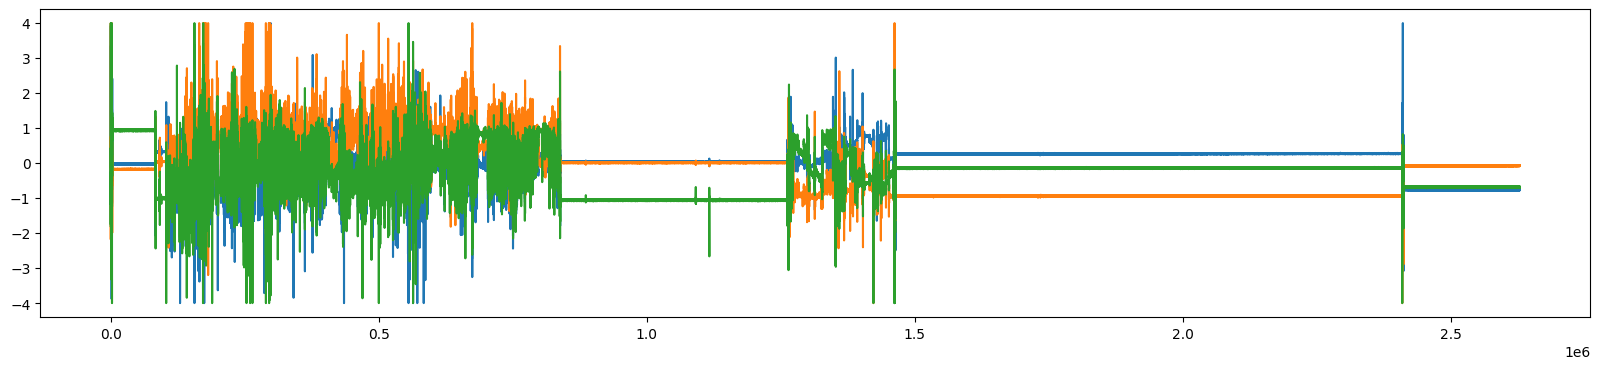

In [ ]:
fig = plt.figure(figsize=(20, 4))
plt.plot(fdata['ax'])
plt.plot(fdata['ay'])
plt.plot(fdata['az'])
# plt.xlim(700000, 750000)

In [ ]:
_temp = pd.DataFrame(columns=rd_cols)
_data = np.random.random((10, 8))
print(_temp)
print(_data)
_temp[data_cols] = _data
_temp

Empty DataFrame
Columns: [ax, ay, az, gx, gy, gz, datetime, yaw, pitch]
Index: []
[[0.85334644 0.19455493 0.81463203 0.28404982 0.25517315 0.70020342
  0.44144167 0.73896129]
 [0.94710487 0.85137299 0.58247542 0.64780137 0.09556857 0.94945826
  0.20616361 0.68989241]
 [0.94191178 0.72929815 0.87821348 0.17568968 0.04613349 0.48667252
  0.34434518 0.78018612]
 [0.52987424 0.7810537  0.05987847 0.56969001 0.6372121  0.69771133
  0.89475228 0.84094105]
 [0.13109762 0.21216318 0.30344177 0.91081281 0.43240088 0.48201715
  0.57896192 0.04048819]
 [0.405174   0.3890619  0.1812183  0.63651569 0.00943616 0.7164723
  0.63810477 0.61951904]
 [0.59677525 0.1263349  0.4212609  0.88699841 0.20026639 0.61929647
  0.05519795 0.25486104]
 [0.16229912 0.8301559  0.02172305 0.97497359 0.95447687 0.65452515
  0.40446652 0.31330032]
 [0.24771384 0.53703142 0.87972907 0.6265092  0.7927146  0.40849764
  0.79193152 0.36640722]
 [0.69026297 0.90673223 0.33485379 0.0603174  0.9955541  0.42875569
  0.4536394  0

,ax,ay,az,gx,gy,gz,datetime,yaw,pitch
0,0.853346,0.194555,0.814632,0.284050,0.255173,0.700203,NaN,0.441442,0.738961
1,0.947105,0.851373,0.582475,0.647801,0.095569,0.949458,NaN,0.206164,0.689892
2,0.941912,0.729298,0.878213,0.175690,0.046133,0.486673,NaN,0.344345,0.780186
3,0.529874,0.781054,0.059878,0.569690,0.637212,0.697711,NaN,0.894752,0.840941
4,0.131098,0.212163,0.303442,0.910813,0.432401,0.482017,NaN,0.578962,0.040488
5,0.405174,0.389062,0.181218,0.636516,0.009436,0.716472,NaN,0.638105,0.619519
6,0.596775,0.126335,0.421261,0.886998,0.200266,0.619296,NaN,0.055198,0.254861
7,0.162299,0.830156,0.021723,0.974974,0.954477,0.654525,NaN,0.404467,0.313300
8,0.247714,0.537031,0.879729,0.626509,0.792715,0.408498,NaN,0.791932,0.366407
9,0.690263,0.906732,0.334854,0.060317,0.995554,0.428756,NaN,0.453639,0.252745


In [ ]:
# Process raw datewise data.
# 1. Sort rows by datetime
# 2. Convert acceleration to g units and gyroscope to degrees/second
# 3. Interpolate to get 50Hz sampling rate.

# Organize raw data into datewise CSV files.
for subj in controls_details["names"]:
    # Check if the subject exists in processed dict.
    if subj not in proc_completed:
        proc_completed[subj] = {}
    for arm in ("left", "right"):
        # List of raw files.
        _rawfiles = glob.glob(pathlib.Path(base_data_dir / "processed" / subj / f"*{arm}*raw*.csv").as_posix())
        
        # Go through the raw files
        for src_fname in _rawfiles:
            # Check of the filename exists in the processed dict.
            if src_fname.split(os.sep)[-1] not in proc_completed[subj]:
                proc_completed[subj] = []
            # organize_processed_data(src_fname, arm, subj, Fs, data_cols,
            #                         accl_scale, gyro_scale)
            pass

In [ ]:
proc_completed

{'C1': [], 'C3': [], 'C4': {}, 'C5': [], 'C2': []}

In [ ]:
# Process raw datewise data.
# 1. Sort rows by datetime
# 2. Convert acceleration to g units and gyroscope to degrees/second
# 3. Interpolate to get 50Hz sampling rate.
arm = "right"
subj = "C1"
_rawfiles = glob.glob(pathlib.Path(base_data_dir / "processed" / subj / f"*{arm}*raw*.csv").as_posix())

In [ ]:
src_fname = _rawfiles[0]
prcd_fname = '_pcrd_'.join(src_fname.split('_raw_'))

# Read data source data.
_rawdata = pd.read_csv(src_fname, sep=",", index_col=None, parse_dates=True)
_rawdata['datetime'] = pd.to_datetime(_rawdata['datetime'])


In [ ]:
# When to dump data to the disk.
n_dump = 3600

# Get the seconds that are recoeded.
_secs = np.sort(np.unique(_rawdata['datetime'].unique()))

# Go through each second and find the number of data points
_data = None
n_count = 0

for _s in _secs:
    # Get time index.
    _inx = _rawdata['datetime'] == _s
    _ninx = np.sum(_inx)
    if _ninx == Fs:
        # All good.
        _tempdf = _rawdata.loc[_inx, :].reset_index(drop=True)
        _tempdf['datetime'] = _s + pd.Timedelta(seconds=dT) * np.arange(0, Fs)
    elif np.abs(_ninx - Fs) < -10:
        # Minon mismatch
        # Interpolate, assuming uniform sampling
        _ynew = interp1d_rawdata(
            yvals=_rawdata.loc[_inx, data_cols].values,
            xold=np.arange(_ninx),
            xnew=np.arange(Fs),
        )
        _tempdf = pd.DataFrame(data=_ynew, columns=data_cols)
        _tempdf['datetime'] = _s + pd.Timedelta(seconds=dT) * np.arange(0, Fs)
        
    # Update dataframe
    if _data is None:
        # Init if it does not exist
        _data = pd.DataFrame(columns=_tempdf.columns)
        _data.to_csv(prcd_fname, sep=",", mode='w', index=False, header=True)
    else:
        _data = pd.concat([_data, _tempdf], axis=0, ignore_index=True)
    
    # Check if data is to be dumped to the disk.
    if n_count == n_dump:
        # Dump data
        _data.to_csv(prcd_fname, sep=",", mode='a', index=False, header=False)
        n_count = 0
        _data = pd.DataFrame(columns=_data.columns)
    else:
        n_count += 1
    
    # Update display
    if n_count % 73 == 0:
        sys.stdout.write(f"\rProcessing {_s} {_ninx:3d} {n_count:6d}")
        sys.stdout.flush()

Processing 2019-09-14T23:43:19.000000000  50   2555